## Libraries to import

In [1]:
!pip install tensorflow
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 10.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Mounted at /content/drive


## Importing the dataset

In [3]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_1d.csv')

### Feature engineering

In [4]:
# adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

In [5]:
all_prices = all_prices.dropna().drop(columns=['Date'])

In [6]:
all_prices.head()

,Gold,Silver,CAD
0,376.600006,5.255,0.734484
1,381.799988,5.282,0.742280
2,387.200012,5.265,0.738443
3,385.899994,5.235,0.737953
4,387.500000,5.302,0.740686


In [7]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    5791 non-null   float64
 1   Silver  5791 non-null   float64
 2   CAD     5791 non-null   float64
dtypes: float64(3)
memory usage: 135.9 KB


In [8]:
all_prices.describe()

,Gold,Silver,CAD
count,5791.000000,5791.000000,5791.000000
mean,1366.947314,19.581992,0.837448
std,657.724911,8.416773,0.100382
min,369.200012,4.810000,0.679486
25%,937.100006,14.401500,0.753807
50%,1288.699951,17.694000,0.798441
75%,1729.799988,24.265000,0.935432
max,4336.399902,53.332001,1.088495


In [9]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)
scaled

array([[0.00186529, 0.0091711 , 0.13446592],
       [0.00317604, 0.00972755, 0.15352722],
       [0.00453721, 0.00937719, 0.14414631],
       ...,
       [0.93836963, 0.93740978, 0.08016895],
       [0.93836963, 0.93740978, 0.08184498],
       [0.93836963, 0.93740978, 0.08890777]])

In [10]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [11]:
max_window = 60

X, y = create_sequences(scaled, max_window)
X.shape

(5731, 60, 3)

### Train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

## GRU implementation

### Hyperparameter tuning

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
def model_builder(hp):
    model = keras.Sequential([
        keras.layers.GRU(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(hp.Int("window", min_value=10, max_value=100, step=10), 3),
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg", values=[1e-6, 1e-5, 1e-4]))
        ),
        keras.layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.GRU(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        ),
        keras.layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.Dense(3, activation="relu") #output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),\
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_rmse", direction="min"),
    max_epochs=40,
    max_consecutive_failed_trials=5,
    seed=42,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [ ]:
tuner.search(x=X_train, y=y_train, validation_split=0.15, callbacks=[stop_early])

Trial 90 Complete [00h 00m 53s]
val_rmse: 0.012734148651361465

Best val_rmse So Far: 0.009476613253355026
Total elapsed time: 00h 41m 17s


### Metrics evaluation of the best model

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_model.save('gru_1d.keras')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 112)        │        39,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 112)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 48)             │        23,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,787 (245.26 KB)

 Trainable params: 62,787 (245.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 112,
 'window': 50,
 'l2_reg': 1e-05,
 'dropout_1': 0.2,
 'units_2': 48,
 'l2_reg2': 1e-06,
 'dropout_2': 0.1,
 'learning_rate': 0.01,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = best_model

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 36.769723474684376
MAE : 13.620253392661267
MAPE: 0.0116326478244101


In [ ]:
baseline = scaler.inverse_transform(X_test[:, -1, :])

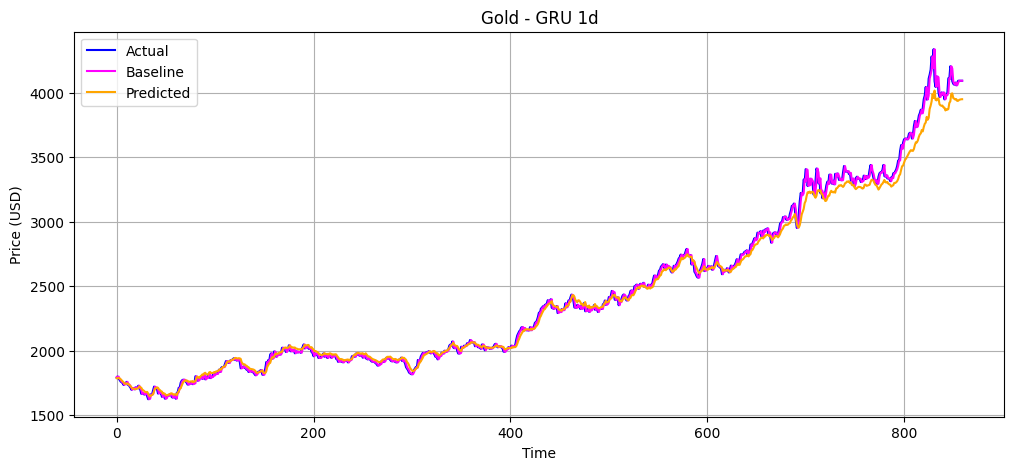

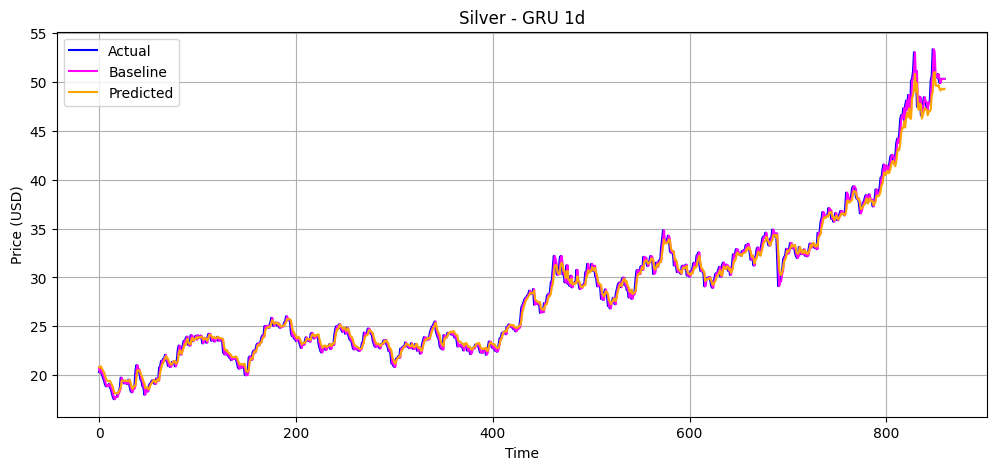

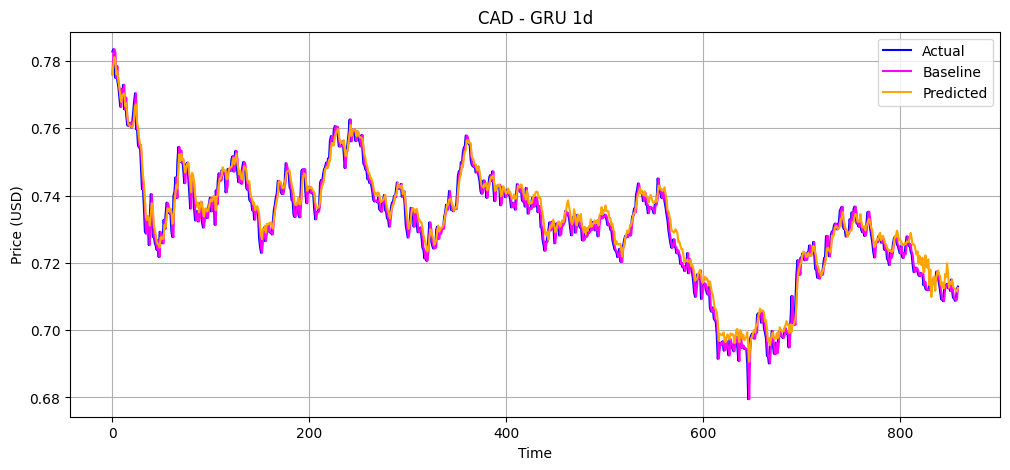

In [ ]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.title(f"{asset_name} - GRU 1d")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [ ]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 40.36816704328671
 RMSE: 63.68321163626411
 MAPE: 1.4360407772648793

Silver
 MAE : 0.4899314747300255
 RMSE: 0.6973073875131008
 MAPE: 1.6884384104087324

CAD
 MAE : 0.0026616599670676298
 RMSE: 0.003363388099455669
 MAPE: 0.365315159649419



### Mean + std

To ensure the model did not randomly achieve good results with the test set

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [14]:
# {'units_1': 112,
#  'window': 50,
#  'l2_reg': 1e-05,
#  'dropout_1': 0.2,
#  'units_2': 48,
#  'l2_reg2': 1e-06,
#  'dropout_2': 0.1,
#  'learning_rate': 0.01,
#  'tuner/epochs': 40,
#  'tuner/initial_epoch': 0,
#  'tuner/bracket': 0,
#  'tuner/round': 0}

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mae_arr = []
rmse_arr = []
mape_arr = []

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

  model = keras.Sequential([
      keras.layers.GRU(
          units=112,
          return_sequences=True,
          input_shape=(50, 3),
          kernel_regularizer=keras.regularizers.l2(1e-05)
      ),
      keras.layers.Dropout(0.2),
      keras.layers.GRU(
          units=48,
          return_sequences=False,
          kernel_regularizer=keras.regularizers.l2(1e-06),
      ),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(3, activation="relu") #output
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(0.01),
      loss='mse',
      metrics=[rmse, mae, mape]
  )

  model.fit(X_train, y_train, epochs=40)

  y_pred = model.predict(X_test)

  y_pred_inv = scaler.inverse_transform(y_pred)
  y_test_inv = scaler.inverse_transform(y_test)

  rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
  mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
  mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

  rmse_arr.append(rmse_val)
  mae_arr.append(mae_val)
  mape_arr.append(mape_val)

  print("RMSE:", rmse_val)
  print("MAE :", mae_val)
  print("MAPE:", mape_val)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0332 - mae: 0.1053 - mape: 54.8702 - rmse: 0.1409
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.9610e-04 - mae: 0.0217 - mape: 12.7028 - rmse: 0.0294
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5856e-04 - mae: 0.0201 - mape: 10.7922 - rmse: 0.0274
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.1374e-04 - mae: 0.0184 - mape: 11.1763 - rmse: 0.0249
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7270e-04 - mae: 0.0177 - mape: 10.8594 - rmse: 0.0241
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1741e-04 - mae: 0.0174 - mape: 10.8267 - rmse: 0.0230
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.5558e-04 - mae: 0.0163 - mape: 9.9935 - rmse: 0.0218
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.3438e-04 - mae: 0.0160 - mape: 11.0747 - rmse: 0.0213
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5889e-04 - m

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0154 - mae: 0.0708 - mape: 37.3466 - rmse: 0.0901
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mae: 0.0226 - mape: 14.0878 - rmse: 0.0305
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1905e-04 - mae: 0.0195 - mape: 11.0817 - rmse: 0.0267
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2272e-04 - mae: 0.0169 - mape: 10.9765 - rmse: 0.0232
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9189e-04 - mae: 0.0167 - mape: 10.8897 - rmse: 0.0226
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.0034e-04 - mae: 0.0169 - mape: 10.9525 - rmse: 0.0227
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.5181e-04 - mae: 0.0176 - mape: 11.6183 - rmse: 0.0238
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0864e-04 - mae: 0.0152 - mape: 10.5778 - rmse: 0.0207
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2034e-04 - mae: 0.0157 - map

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0218 - mae: 0.0881 - mape: 52.8629 - rmse: 0.1148
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - mae: 0.0254 - mape: 14.1840 - rmse: 0.0336
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2413e-04 - mae: 0.0199 - mape: 11.9259 - rmse: 0.0269
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4102e-04 - mae: 0.0191 - mape: 11.4280 - rmse: 0.0255
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.0794e-04 - mae: 0.0170 - mape: 10.8712 - rmse: 0.0229
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2349e-04 - mae: 0.0170 - mape: 10.8465 - rmse: 0.0230
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.2349e-04 - mae: 0.0174 - mape: 11.2380 - rmse: 0.0232
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.4565e-04 - mae: 0.0159 - mape: 10.5503 - rmse: 0.0215
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2545e-04 - mae: 0.0157 - ma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0321 - mae: 0.0919 - mape: 46.9684 - rmse: 0.1215
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - mae: 0.0238 - mape: 12.8796 - rmse: 0.0320
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.4950e-04 - mae: 0.0195 - mape: 11.3754 - rmse: 0.0270
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1904e-04 - mae: 0.0189 - mape: 11.2060 - rmse: 0.0266
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7064e-04 - mae: 0.0173 - mape: 10.6289 - rmse: 0.0240
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.8892e-04 - mae: 0.0178 - mape: 11.3652 - rmse: 0.0244
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.0066e-04 - mae: 0.0164 - mape: 10.6834 - rmse: 0.0227
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4565e-04 - mae: 0.0157 - mape: 10.4981 - rmse: 0.0215
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0932e-04 - mae: 0.0152 - ma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0256 - mae: 0.0866 - mape: 44.6928 - rmse: 0.1176
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0224 - mape: 13.2111 - rmse: 0.0303
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.5829e-04 - mae: 0.0203 - mape: 12.2355 - rmse: 0.0274
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2595e-04 - mae: 0.0183 - mape: 11.8159 - rmse: 0.0251
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2485e-04 - mae: 0.0168 - mape: 10.9773 - rmse: 0.0232
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9321e-04 - mae: 0.0163 - mape: 11.1332 - rmse: 0.0224
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.7304e-04 - mae: 0.0165 - mape: 11.2294 - rmse: 0.0221
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.7520e-04 - mae: 0.0166 - mape: 11.7632 - rmse: 0.0222
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.3494e-04 - mae: 0.0159 - m

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0186 - mae: 0.0859 - mape: 45.0876 - rmse: 0.1076
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - mae: 0.0227 - mape: 13.3827 - rmse: 0.0305
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3153e-04 - mae: 0.0196 - mape: 11.3385 - rmse: 0.0270
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.9136e-04 - mae: 0.0179 - mape: 10.6550 - rmse: 0.0243
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4283e-04 - mae: 0.0158 - mape: 9.7637 - rmse: 0.0215
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.0524e-04 - mae: 0.0169 - mape: 10.8527 - rmse: 0.0228
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1368e-04 - mae: 0.0155 - mape: 10.6243 - rmse: 0.0209
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7165e-04 - mae: 0.0147 - mape: 9.5714 - rmse: 0.0199
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.7826e-04 - mae: 0.0167 - map

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0163 - mae: 0.0754 - mape: 39.8625 - rmse: 0.0946
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011 - mae: 0.0234 - mape: 13.1507 - rmse: 0.0310
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7.5897e-04 - mae: 0.0193 - mape: 11.7542 - rmse: 0.0258
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2962e-04 - mae: 0.0171 - mape: 11.1412 - rmse: 0.0234
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.7549e-04 - mae: 0.0163 - mape: 10.3772 - rmse: 0.0220
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8270e-04 - mae: 0.0167 - mape: 11.6264 - rmse: 0.0224
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.1176e-04 - mae: 0.0170 - mape: 11.1323 - rmse: 0.0229
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5947e-04 - mae: 0.0166 - mape: 11.6509 - rmse: 0.0219
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2120e-04 - mae: 0.0158 - ma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0203 - mae: 0.0806 - mape: 49.9835 - rmse: 0.1026
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011 - mae: 0.0229 - mape: 12.4733 - rmse: 0.0312
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.2900e-04 - mae: 0.0198 - mape: 12.2473 - rmse: 0.0270
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7862e-04 - mae: 0.0179 - mape: 10.7692 - rmse: 0.0243
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.3668e-04 - mae: 0.0173 - mape: 11.2321 - rmse: 0.0235
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8074e-04 - mae: 0.0163 - mape: 10.6574 - rmse: 0.0223
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6158e-04 - mae: 0.0165 - mape: 10.6138 - rmse: 0.0220
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4015e-04 - mae: 0.0159 - mape: 10.5324 - rmse: 0.0215
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.2966e-04 - mae: 0.0157 - m

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0215 - mae: 0.0870 - mape: 55.0733 - rmse: 0.1066
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0013 - mae: 0.0250 - mape: 13.3289 - rmse: 0.0333
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6717e-04 - mae: 0.0190 - mape: 10.8320 - rmse: 0.0259
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0717e-04 - mae: 0.0183 - mape: 11.2272 - rmse: 0.0248
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2155e-04 - mae: 0.0171 - mape: 11.1665 - rmse: 0.0231
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0547e-04 - mae: 0.0170 - mape: 11.3177 - rmse: 0.0229
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3377e-04 - mae: 0.0158 - mape: 10.1210 - rmse: 0.0214
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4130e-04 - mae: 0.0157 - mape: 10.5020 - rmse: 0.0214
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4484e-04 - mae: 0.0158 - ma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0156 - mae: 0.0745 - mape: 38.8524 - rmse: 0.0934
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.0717e-04 - mae: 0.0207 - mape: 11.7406 - rmse: 0.0282
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.9316e-04 - mae: 0.0196 - mape: 11.9719 - rmse: 0.0265
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8425e-04 - mae: 0.0163 - mape: 11.5168 - rmse: 0.0223
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4024e-04 - mae: 0.0161 - mape: 10.7316 - rmse: 0.0215
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.6312e-04 - mae: 0.0157 - mape: 10.2752 - rmse: 0.0219
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.4231e-04 - mae: 0.0160 - mape: 10.1069 - rmse: 0.0215
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.2542e-04 - mae: 0.0156 - mape: 10.6054 - rmse: 0.0211
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1746e-04 - mae: 0.015

In [16]:
mae_arr = np.array(mae_arr)
rmse_arr = np.array(rmse_arr)
mape_arr = np.array(mape_arr)

print("RMSE: mean =", np.mean(rmse_arr), '|| std dev =', np.std(rmse_arr))
print("MAE : mean =", np.mean(mae_arr), '|| std dev =', np.std(mae_arr))
print("MAPE: mean =", np.mean(mape_arr), '|| std dev =', np.std(mape_arr))

RMSE: mean = 122.95768537389388 || std dev = 39.369229478810105
MAE : mean = 51.275520892757775 || std dev = 21.25859757094336
MAPE: mean = 0.036102802387680925 || std dev = 0.009685139447163621


### Final model

Model trained on all the dataset set to be used for future predictions

In [17]:
model = keras.Sequential([
    keras.layers.GRU(
        units=112,
        return_sequences=True,
        input_shape=(50, 3),
        kernel_regularizer=keras.regularizers.l2(1e-05)
    ),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(
        units=48,
        return_sequences=False,
        kernel_regularizer=keras.regularizers.l2(1e-06),
    ),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(3, activation="relu") #output
])

model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss='mse',
    metrics=[rmse, mae, mape]
)

model.fit(X, y, epochs=40)

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0188 - mae: 0.0780 - mape: 38.2712 - rmse: 0.0971
Epoch 2/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - mae: 0.0261 - mape: 3939.0994 - rmse: 0.0343
Epoch 3/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.7513e-04 - mae: 0.0206 - mape: 20051.3809 - rmse: 0.0278
Epoch 4/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.4135e-04 - mae: 0.0200 - mape: 45081.6758 - rmse: 0.0273
Epoch 5/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.8368e-04 - mae: 0.0180 - mape: 7817.8726 - rmse: 0.0243
Epoch 6/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7.0498e-04 - mae: 0.0183 - mape: 854.6708 - rmse: 0.0248
Epoch 7/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.4482e-04 - mae: 0.0176 - mape: 1934.7288 - rmse: 0.0235
Epoch 8/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.0311e-04 - mae: 0.0168 - mape: 188641.5000 - rmse: 0.0226
Epoch 9/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.9623e-04 -

In [18]:
model.save('gru_1d.keras')